In [1]:
!git clone https://github.com/AbdullahAlMahmudAdib/cnn-phone-classifier.git
%cd cnn-phone-classifier
!ls -R


Cloning into 'cnn-phone-classifier'...
remote: Enumerating objects: 58, done.
remote: Counting objects: 100% (58/58), done.
remote: Compressing objects: 100% (44/44), done.
remote: Total 58 (delta 9), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (58/58), 5.34 MiB | 15.63 MiB/s, done.
Resolving deltas: 100% (9/9), done.
/content/cnn-phone-classifier
.:
dataset  README.md

./dataset:
phone

./dataset/phone:
img01.jpg  img03.jpg  img05.jpg  img07.jpg  img09.jpg  README.md
img02.jpg  img04.jpg  img06.jpg  img08.jpg  img10.jpg


In [2]:
import os, random, numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)


Using device: cpu


In [4]:
transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize((0.2860,), (0.3530,))
])


In [7]:
train_dataset = datasets.FashionMNIST(
    root="data", train=True, download=True, transform=transform
)
test_dataset = datasets.FashionMNIST(
    root="data", train=False, download=True, transform=transform
)

val_ratio = 0.1
val_size = int(len(train_dataset) * val_ratio)
train_size = len(train_dataset) - val_size

train_ds, val_ds = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=64, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False)

class_names = train_dataset.classes
print(class_names)


['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


In [8]:
class CNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64*7*7, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

model = CNN().to(device)
print(model)


CNN(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3136, out_features=128, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [10]:
def accuracy(logits, y):
    preds = logits.argmax(dim=1)
    return (preds == y).float().mean().item()

num_epochs = 5
history = {"train_loss":[], "val_loss":[], "train_acc":[], "val_acc":[]}

for epoch in range(num_epochs):
    model.train()
    train_loss, train_acc = 0, 0

    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_acc += accuracy(logits, y)

    train_loss /= len(train_loader)
    train_acc /= len(train_loader)

    model.eval()
    val_loss, val_acc = 0, 0
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            loss = criterion(logits, y)
            val_loss += loss.item()
            val_acc += accuracy(logits, y)

    val_loss /= len(val_loader)
    val_acc /= len(val_loader)

    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["train_acc"].append(train_acc)
    history["val_acc"].append(val_acc)

    print(f"Epoch {epoch+1}: "
          f"Train Acc={train_acc:.3f}, Val Acc={val_acc:.3f}")


Epoch 1: Train Acc=0.831, Val Acc=0.885
Epoch 2: Train Acc=0.891, Val Acc=0.903
Epoch 3: Train Acc=0.907, Val Acc=0.911
Epoch 4: Train Acc=0.917, Val Acc=0.914
Epoch 5: Train Acc=0.924, Val Acc=0.917


In [12]:
os.makedirs("model", exist_ok=True)
torch.save(model.state_dict(), "model/210144.pth")
print("Model saved to model/210144.pth")


Model saved to model/210144.pth


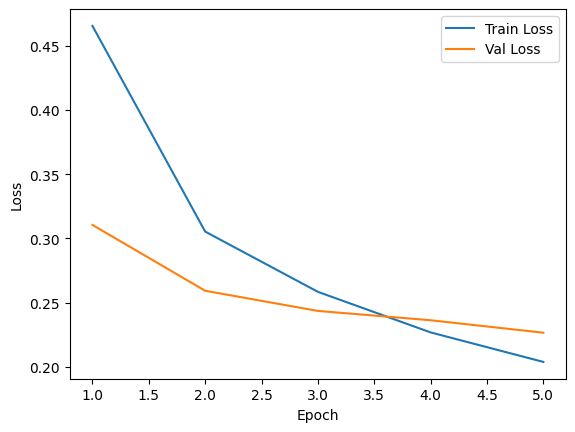

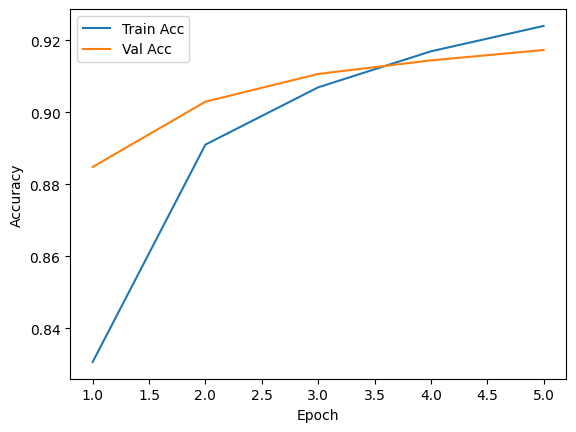

In [13]:
epochs = range(1, num_epochs+1)

plt.figure()
plt.plot(epochs, history["train_loss"], label="Train Loss")
plt.plot(epochs, history["val_loss"], label="Val Loss")
plt.legend(); plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.show()

plt.figure()
plt.plot(epochs, history["train_acc"], label="Train Acc")
plt.plot(epochs, history["val_acc"], label="Val Acc")
plt.legend(); plt.xlabel("Epoch"); plt.ylabel("Accuracy")
plt.show()


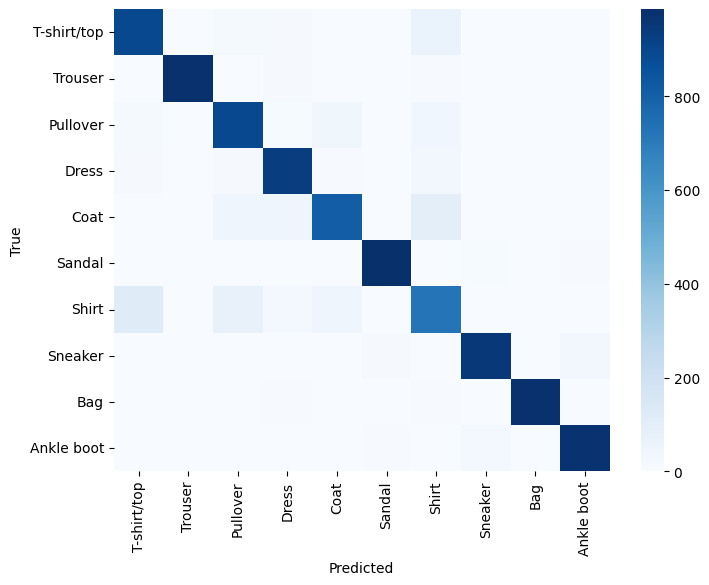

In [14]:
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        preds = model(x).argmax(dim=1).cpu().numpy()
        y_pred.extend(preds)
        y_true.extend(y.numpy())

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Predicted"); plt.ylabel("True")
plt.show()


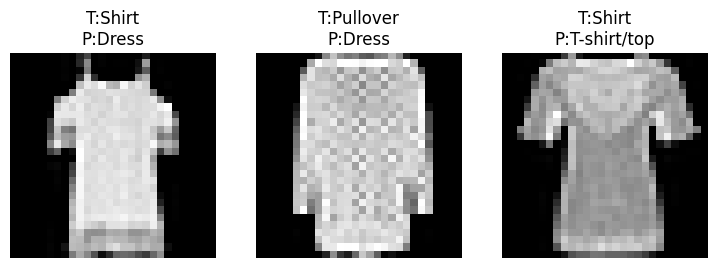

In [15]:
mis = []
with torch.no_grad():
    for i in range(len(test_dataset)):
        x, y = test_dataset[i]
        pred = model(x.unsqueeze(0).to(device)).argmax(dim=1).item()
        if pred != y:
            mis.append((x, y, pred))

samples = random.sample(mis, 3)

plt.figure(figsize=(9,3))
for i,(x,y,p) in enumerate(samples):
    plt.subplot(1,3,i+1)
    plt.imshow(x.squeeze(), cmap="gray")
    plt.title(f"T:{class_names[y]}\nP:{class_names[p]}")
    plt.axis("off")
plt.show()


In [17]:
phone_dir = "dataset/phone"
files = sorted(os.listdir(phone_dir))

images = []
for f in files:
    if f.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):
        img = Image.open(os.path.join(phone_dir, f)).convert("L")
        images.append(transform(img))

batch = torch.stack(images).to(device)

with torch.no_grad():
    probs = torch.softmax(model(batch), dim=1)
    conf, pred = probs.max(dim=1)

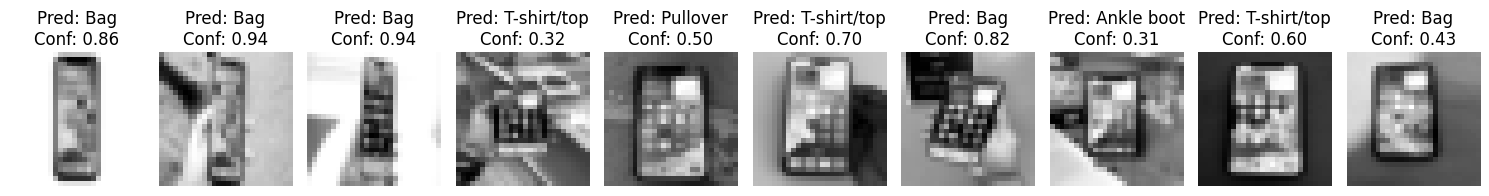

In [18]:
plt.figure(figsize=(15, 5))
for i, (c, p, img_tensor) in enumerate(zip(conf, pred, images)):
    plt.subplot(1, len(images), i + 1)
    plt.imshow(img_tensor.squeeze().cpu().numpy(), cmap="gray")
    plt.title(f"Pred: {class_names[p]}\nConf: {c:.2f}")
    plt.axis("off")
plt.tight_layout()
plt.show()

In [19]:
torch.save(model.state_dict(), "model/210144.pth")
